# Solving time dependent systems

## Stochastic heat equation

We will solve 

\begin{align}
&du = \Delta u dt  + dW_t \\
&u(0, x) = g(x) \\
&u(t,0) = u(t, 1) = 0
\end{align}

where $\frac{dW_t}{dt}$ is space time white noise. We use an implicit EM method with step size $h$

\begin{align}
&u_0 = g(x) \\
&u_{n+1} = u_n + h \Delta u_{n+1} + \Delta W_n
\end{align}
where 
$$
\Delta W_n \sim \mathcal{N}(0, h I)
$$


Hence 
\begin{align}
&(-h \Delta + I )u_{n+1} = u_n + \Delta W_n\\
&u(t,0) = u(t, 1) = 0
\end{align}

At each step we solve

\begin{align}
[(-h \Delta + I )u_{n+1}, \psi] = [u_n,\psi] + \sqrt{h}[\Delta \xi_n, \psi]
\end{align}



In [1]:
import jax.numpy as jnp
from jax import random, vmap, jit, grad
import jax.scipy as scipy


from jax.config import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

from utils_rough_pde import *
from utils_elliptic_coef import *

from utils_optim import kernel_linear_solver

from tqdm import tqdm

import time

C:\Users\Matthieu\AppData\Local\Temp\ipykernel_7864\112495811.py:6: DeprecationWarning: Accessing jax.config via the jax.config submodule is deprecated.
  from jax.config import config


In [2]:
# Define the domain of the problem
lower = 0.0
upper = 1.0
x = jnp.linspace(lower, upper, 10000)
boundary = jnp.array([[lower, upper]]).T


In [3]:
N_m = 500
centers = jnp.linspace(lower, upper, int(N_m))[1:-1]
N_tent = len(centers)
epsilon = centers[1] - centers[0]
epsilon

Array(0.00200401, dtype=float64)

In [4]:
stiffness_matrix = vmap_compute_energy_ip(epsilon, centers, centers)
L2_matrix = vmap_compute_l2_ip(epsilon, centers, centers)
L_stiff = scipy.linalg.cho_factor(stiffness_matrix + 1e-10*jnp.eye(N_tent))
L_L2 = scipy.linalg.cholesky(L2_matrix + 1e-10*jnp.eye(N_tent))

#L = scipy.linalg.cholesky(L2_matrix, lower=True)
#stiffness_matrix, L2_matrix

In [5]:
# Build the measurements of the initial condition

# Define the support of the test function 
support = jnp.array([centers - epsilon
                     , centers + epsilon]).T

from scipy.special import roots_legendre
n_order = 10
x_q, w_q = roots_legendre(n_order)
x_interval, w_interval = vmap_root_interval(x_q, w_q, support)

from utils_rough_pde import vmap_integrate_f_test_functions
# Create measurements of f 
root_psi, w_psi = vmap_root_interval(x_q, w_q, support)
psi_matrix = vmap_tent_vector(root_psi, epsilon, centers)
psi_matrix = psi_matrix * w_psi

# Generating white noise

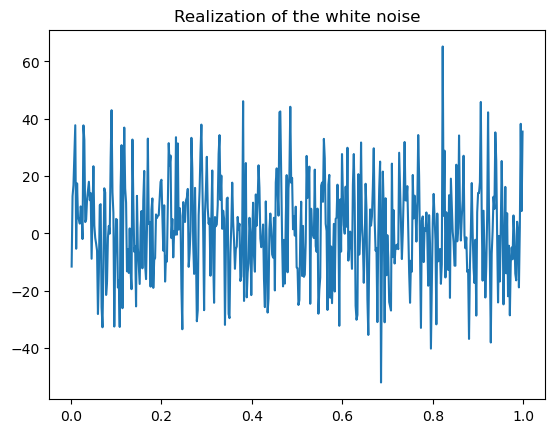

In [6]:
key = random.PRNGKey(312)
xi =  L_L2@random.normal(key, (N_tent,))
plt.plot(centers, xi)
plt.title('Realization of the white noise')
plt.show()

In [7]:
# Solve for this realization
length_scale = 1.0
bc = jnp.zeros(shape = (2, )) 
h = 0.001 # time step

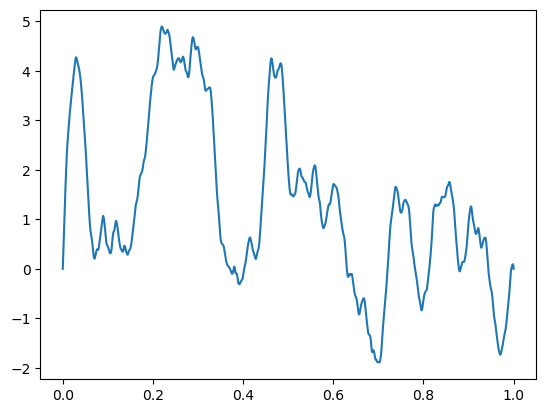

In [8]:
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, h)
root_identity = jnp.ones_like(root_psi)

linear_solver.build_matrices(root_identity)
linear_solver.solve(xi, None, L_stiff)
plt.plot(x, linear_solver.evaluate_solution(x))

# Poisson equation

Let us solve 

$$
-\Delta u = \xi
$$

Let 
$$u = \sum_{i=1}^N c_i \psi_i$$

Then in integral form this is 
$$
\langle -\Delta u , \psi_j \rangle = \langle \xi, \psi_j \rangle
$$
which can be reformulated as 

\begin{align}
&\sum_{i=1} c_i \langle  \nabla \psi_i, \nabla \psi_j \rangle = \langle \xi, \psi_j \rangle \\
&\Theta \bold{c} = \langle \xi, \boldsymbol{\psi} \rangle
\end{align}

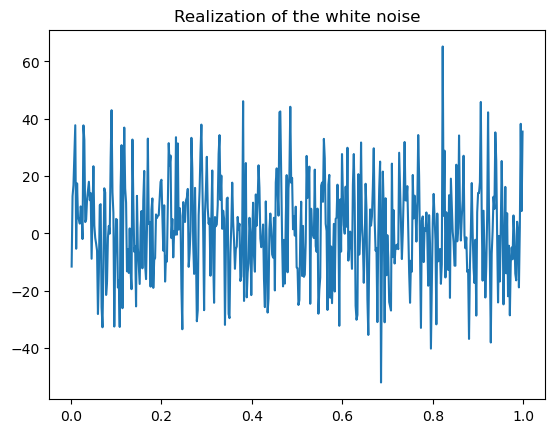

In [9]:
key = random.PRNGKey(312)
xi =  L_L2@random.normal(key, (N_tent,))
plt.plot(centers, xi)
plt.title('Realization of the white noise')
plt.show()

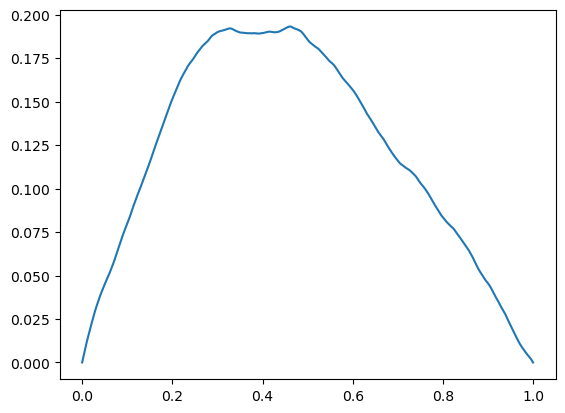

In [10]:
#c_tent = scipy.linalg.cho_solve(L_stiff, xi)
c_tent = scipy.linalg.solve(stiffness_matrix/epsilon**2, xi, assume_a='pos')
plt.plot(x, evaluate_tent(c_tent, x, epsilon, centers))

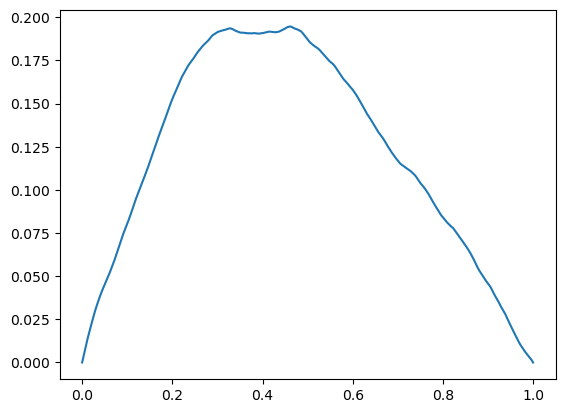

In [11]:
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, 1.0)

linear_solver.build_matrices(jnp.zeros_like(root_psi))
linear_solver.solve(xi, None, L_stiff)
plt.plot(x, linear_solver.evaluate_solution(x))

Let us solve 

$$
-\Delta u + u = \xi
$$

Let 
$$u = \sum_{i=1}^N c_i \psi_i$$

Then in integral form this is 
$$
\langle -\Delta u , \psi_j \rangle + \langle  u , \psi_j \rangle = \langle \xi, \psi_j \rangle
$$
which can be reformulated as 

\begin{align}
&\sum_{i=1} c_i \langle  \nabla \psi_i, \nabla \psi_j \rangle +\sum_{i=1}^N c_i \langle \psi_i, \psi_j \rangle = \langle \xi, \psi_j \rangle \\
&(\Theta + \Gamma)\bold{c} = \langle \xi, \boldsymbol{\psi} \rangle
\end{align}

In [12]:
h = 1e-2
sigma = 0.1

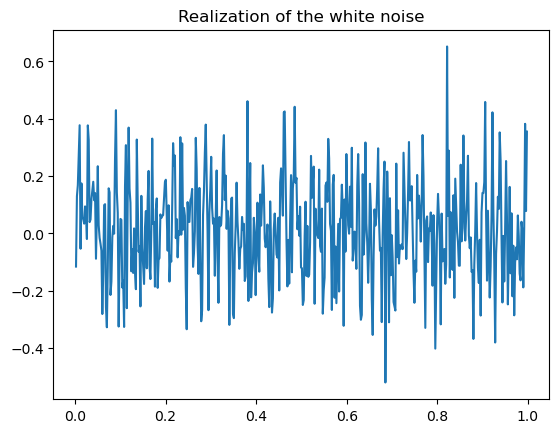

In [13]:
key = random.PRNGKey(312)
xi =  random.normal(key, (N_tent,))
plt.plot(centers, jnp.sqrt(h)*sigma*L_L2@xi)
plt.title('Realization of the white noise')
plt.show()

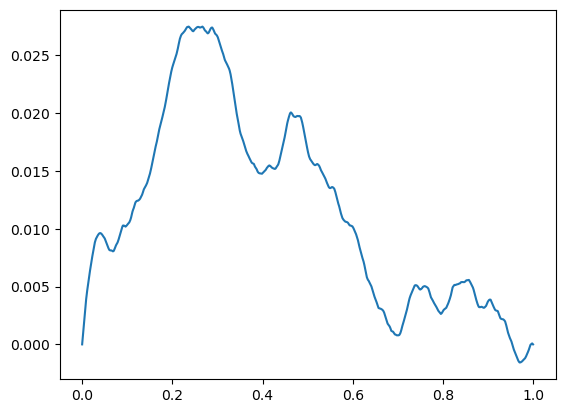

In [14]:
L_cho = scipy.linalg.cho_factor(h*stiffness_matrix/epsilon**2 + L2_matrix)
#c_tent = scipy.linalg.solve(h*stiffness_matrix/epsilon**2 + L2_matrix , jnp.sqrt(h)*sigma*L_L2@xi, assume_a= 'pos')
c_tent = scipy.linalg.cho_solve(L_cho, jnp.sqrt(h)*sigma*L_L2@xi)
plt.plot(x, evaluate_tent(c_tent, x, epsilon, centers))
#plt.plot(centers, xi)

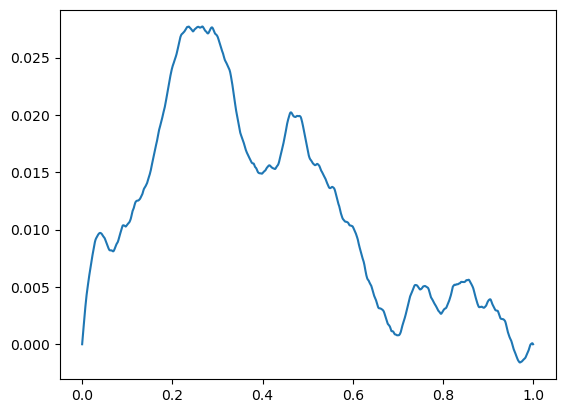

In [15]:
linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, h)

linear_solver.build_matrices(root_identity)
linear_solver.solve(jnp.sqrt(h)*sigma*L_L2@xi, None, L_stiff)
plt.plot(x, linear_solver.evaluate_solution(x))

# Solving the stochastic heat equation

Let $u = \sum_{i=1}^N c_i \psi_i$. Then 

\begin{align}
du_t = \sum_{i=1}^N c_i(t) \Delta \psi_i dt  + \sigma dW_t
\end{align}

which can be expressed in integral form as 

\begin{align}
\langle du_t, \psi_j \rangle = \sum_{i=1}^N dc_i(t)\langle \psi_i, \psi_j \rangle=-\sum_{i=1}^N c_i(t)\langle \nabla \psi_i, \nabla \psi_j \rangle dt +  \sigma \langle dW_t, \psi_j\rangle
\end{align}

or 
\begin{align}
d \Gamma \bold{c}(t) = -\Theta\bold{c}dt +  \sigma\langle dW_t, \boldsymbol{\psi}\rangle.
\end{align}

This can be written as the system of SDEs
\begin{align}
d\bold{c}(t) = -\Gamma^{-1}\Theta\bold{c}dt +  \sigma\Gamma^{-\frac{1}{2}}dW_t
\end{align}

with 
\begin{align}
&\Theta_{ij} =  \langle \nabla \psi_i, \nabla \psi_j \rangle \\
&\Gamma_{ij} =  \langle  \psi_i, \psi_j \rangle
\end{align}

We will discretize this using an implicit Euler scheme:
\begin{align}
\bold{c}_{n+1} = \bold{c}_n - h\Gamma^{-1}\Theta \bold{c}_{n+1} + \sigma\Gamma^{-\frac{1}{2}}\Delta W_n
\end{align}
which becomes
\begin{align}
(h\Gamma^{-1}\Theta + I)\bold{c}_{n+1} = \bold{c}_n +   \sigma\Gamma^{-\frac{1}{2}}\Delta W_n
\end{align}

We can alternatively write

$$
\Gamma \bold{c}_{n+1} = \Gamma\bold{c}_n - h\Theta \bold{c}_{n+1} + \sigma\Gamma^{\frac{1}{2}}\Delta W_n
$$
which becomes

$$
(h\Theta + \Gamma) \bold{c}_{n+1} = \Gamma\bold{c}_n  + \sigma\Gamma^{\frac{1}{2}}\Delta W_n
$$

# Interpolating the initial condition

In [16]:
u0 = lambda x: jnp.sin(2*jnp.pi*x)
g_init = u0(x) 

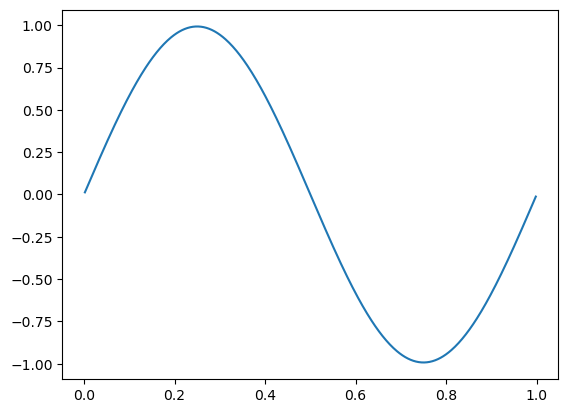

In [17]:
y_init = u0(root_psi)
y_init = vmap_integrate_f_test_functions(y_init, psi_matrix)

plt.plot(centers, y_init)

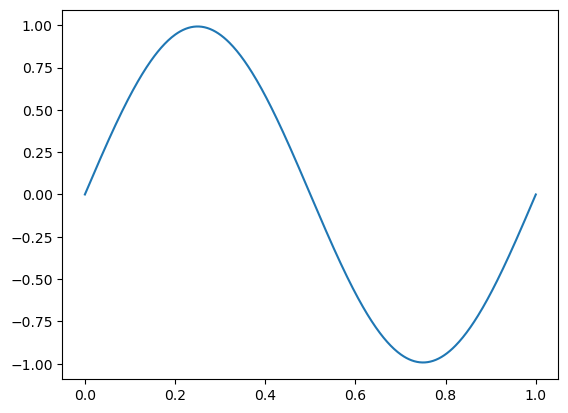

In [18]:
c_init = jnp.linalg.solve(L2_matrix, y_init)
plt.plot(x, evaluate_tent(c_init, x, epsilon, centers))

In [19]:
# def integrate_stochastic_heat(T, h, c_init, sigma, stiffness_matrix, L2_matrix, key):
#     L_L2 = scipy.linalg.cholesky(L2_matrix)
#     N_tent = L2_matrix.shape[0]
   

#     # Number of time steps
#     N = int(T/h)
#     time = jnp.arange(h, T+h, h)
#     c = c_init

#     noise = []

#     for i in range(N):
#         key, subkey = random.split(key)
#         # Sample from the space time white noise
#         xi = random.normal(subkey, (N_tent,))
#         noise.append( jnp.sqrt(h)*sigma*L_L2@xi)
#         c = c  - h*stiffness_matrix@c + jnp.sqrt(h)*sigma*L_L2@xi
#     return c, noise

In [20]:
def integrate_stochastic_heat_implicit(T, h, c_init, sigma, stiffness_matrix, L2_matrix, key, record = False):
    L_L2 = scipy.linalg.cholesky(L2_matrix)
    A = scipy.linalg.cho_factor(h*stiffness_matrix/epsilon**2 + L2_matrix)

    N_tent = L2_matrix.shape[0]
   

    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    c = c_init

    history = []
    noise = []
    for i in range(N):
        key, subkey = random.split(key)
        # Sample from the space time white noise
        xi = sigma*L_L2@random.normal(subkey, (N_tent,))
        c = scipy.linalg.cho_solve(A, L2_matrix@c + jnp.sqrt(h)*xi)
        if record:
            history.append(c)
            noise.append(xi)
    if record:
        return c, jnp.stack(history), jnp.stack(noise)
    return c

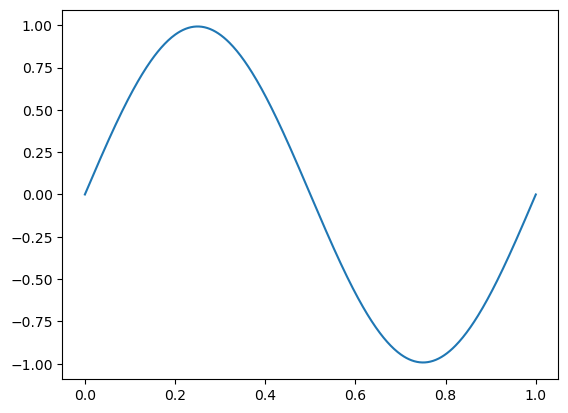

In [21]:
y_init = u0(root_psi)
y_init = vmap_integrate_f_test_functions(y_init, psi_matrix)
c_init = scipy.linalg.solve(L2_matrix, y_init, assume_a='pos')
plt.plot(x, evaluate_tent(c_init, x, epsilon, centers))
plt.show()

In [22]:
h = 1/600#1e-3
sigma = 10.0
T= 10.0
start = time.time()
c_final, c_history, white_noise = integrate_stochastic_heat_implicit(T, h, c_init ,sigma, stiffness_matrix, L2_matrix,  random.key(1), record = True)
end = time.time()
print('Time taken:', end - start)
pred_fem = vmap(evaluate_tent, (0, None, None, None))(c_history, x, epsilon, centers)

Time taken: 13.032110214233398


# Implicit Euler

In [23]:
def implicit_Euler_linear(T, h, linear_solver, y_init,sigma, stiffness_matrix, L2_matrix, reg, key, record = False):
    L_stiff = scipy.linalg.cho_factor(stiffness_matrix)
    L_L2 = scipy.linalg.cholesky(L2_matrix)
    N_tent = L2_matrix.shape[0]
   

    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    y = y_init

    noise = []
    history = []
    for i in range(N):
        key, subkey = random.split(key)
        # Sample from the space time white noise
        xi =  sigma*L_L2@random.normal(subkey, (N_tent,))
        

        # Create the right hand side
        rhs = y +  jnp.sqrt(h)*xi
        #print(xi[0])

        # Solve the linear system
        linear_solver.solve(rhs, reg, L_stiff, compute_residuals = False)

        # Update the rhs
        y = linear_solver.evaluate_solution_psi()    
        if record:
            history.append(linear_solver.c)    
            noise.append(xi)
        #print(y.shape)
    if record:
        return y, linear_solver, jnp.stack(history), jnp.stack(noise)
    return y, linear_solver 

# Integration

In [24]:
length_scale = 0.1
bc = jnp.zeros(shape = (2, )) 



linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, h)
root_identity = jnp.ones_like(root_psi)

start = time.time()
linear_solver.build_matrices(root_identity)
linear_solver.create_K_psi()
linear_solver.create_K_eval(x)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

start = time.time()
y, linear_solver, c_kernel_history, _= implicit_Euler_linear(T, h, linear_solver, y_init, sigma, stiffness_matrix, L2_matrix , None, random.key(1), record = True)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Time to build the matrices 2.5575
Time to integrate the system 14.44325


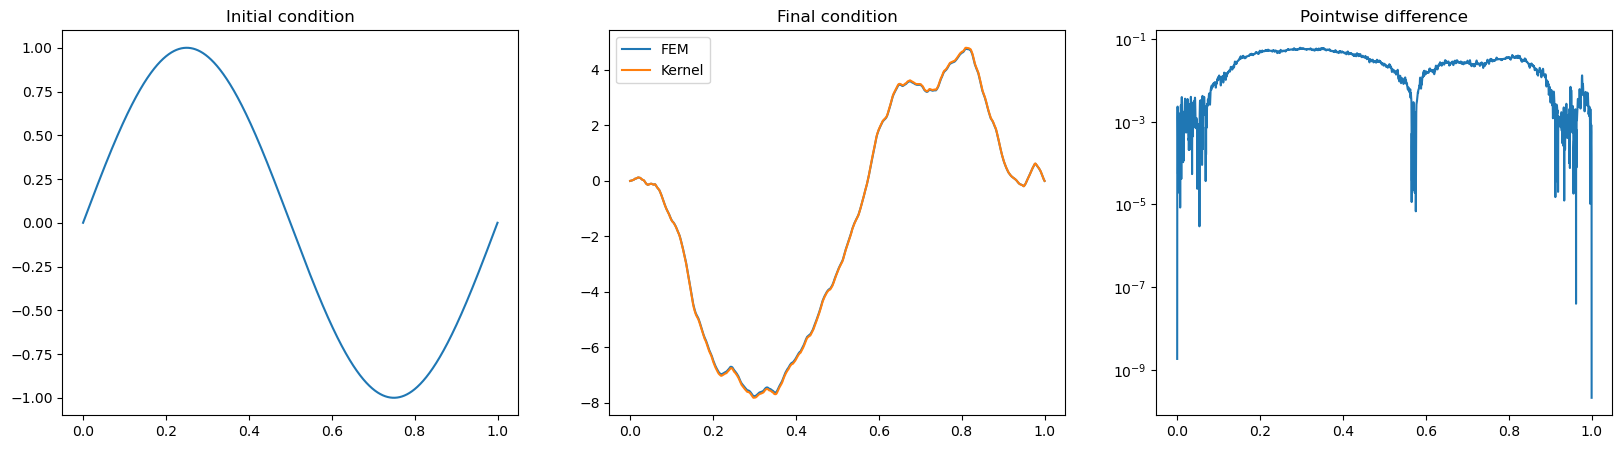

In [25]:
# Plot 2 figures with the initial condition and the final condition

fig, ax = plt.subplots(1, 3, figsize = (20, 5))
ax[0].plot(x, g_init)
ax[0].set_title('Initial condition')
ax[1].plot(x, evaluate_tent(c_final, x, epsilon, centers), label= "FEM")
ax[1].plot(x, linear_solver.evaluate_solution(x), label= "Kernel")
ax[1].legend()
ax[1].set_title('Final condition')
ax[2].plot(x, jnp.abs(evaluate_tent(c_final, x, epsilon, centers) - linear_solver.evaluate_solution(x)))
ax[2].set_title('Pointwise difference')
ax[2].set_yscale('log')
plt.show()

In [77]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [78]:
prediction_dictionary = {"FEM": pred_fem, "Kernel": pred_kernel}

In [79]:
def save_plots(prediction_dictionary, noise_results, T, folder_name, n_frames = 1):
    import os
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    
    name_1, name_2 = prediction_dictionary.keys()
    pred_1, pred_2  = prediction_dictionary.values()
    pred_1, pred_2 = pred_1[::n_frames], pred_2[::n_frames]

    centers, noise = noise_results



    n_frames = pred_1.shape[0] 
    h = T/n_frames

    #print(T, n_frames, h)
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    for i in tqdm(range(n_frames)):
        ax[0].cla()
        ax[1].cla()
        ax[2].cla()

        ax[0].set_ylim(jnp.min(pred_1) - 0.1, jnp.max(pred_1) + 0.1)
        ax[1].set_yscale('log')
        ax[1].set_ylim(1e-7, 1e-0)
        ax[2].set_ylim(jnp.min(noise) - 0.1, jnp.max(noise) + 0.1)

        ax[0].set_xlabel(r'$x$')
        ax[1].set_xlabel(r'$x$')
        ax[2].set_xlabel(r'$x$')

        ax[0].set_ylabel(r'$u(x)$')
        ax[1].set_ylabel(r'$|u^\dagger(x) - u^*(x)|$')
        ax[2].set_ylabel(r'$\xi (x)$')

        ax[0].plot(x, pred_1[i], label = name_1)
        ax[0].plot(x, pred_2[i], label = name_2)
        ax[0].legend()
        ax[0].set_title('Solution')

        ax[1].plot(x, jnp.abs(pred_1[i] - pred_2[i]))
        ax[1].set_title('Pointwise difference')

        ax[2].plot(centers, noise[i])
        ax[2].set_title('White noise')

        # Create a title for the whole plot
        fig.suptitle(r'Solution at time ${:03f}$'.format(i*h))

        # Save the plot
        fig.savefig(folder_name + 'solution_{:03d}.png'.format(i))

In [80]:
save_plots(prediction_dictionary, (centers, white_noise), T, 'figures/FEM/', n_frames = 10*2)

  0%|          | 0/300 [00:00<?, ?it/s]

 59%|█████▊    | 176/300 [01:13<00:52,  2.37it/s]

# Benchmark: stochastic heat equation with spectral decomposition

Let 
$$
u = \sum_{i=1}^\infty u_i(t)  \sqrt{2}\sin(i\pi x)
$$
Let 
\begin{align}
\phi_i &=  \sqrt{2}\sin(i\pi x) \\
-\Delta \phi_i &= i^2 \pi^2 \sqrt{2} \phi_i = \lambda_i \phi_i
\end{align}
Then the weak solution is given by 

$$
\langle du(t), \phi_i\rangle = - \langle u(t), -\Delta \phi_i  \rangle + \sigma \langle dW_t, \phi_i\rangle 
$$

Let 
$$
dW_t = \sum_{i=1} dB_i(t) \phi_i
$$
we BM in time, white noise is space. The above then becomes

$$
du_i(t) = - \lambda_i  u_i(t)dt + \sigma dB_i(t)
$$
which is an OU process and can be simulated accurately. We will use an impicit EM.

5.1


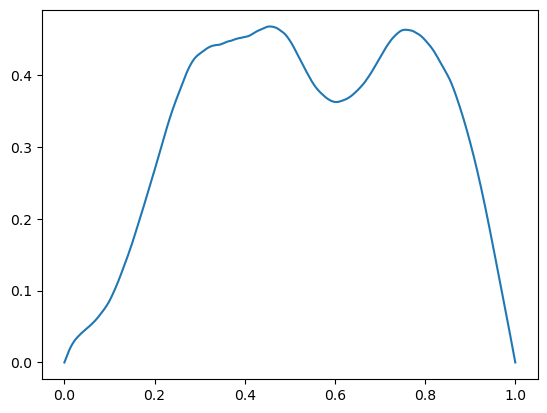

In [20]:
key = random.PRNGKey(1257)
n_coef =N_m

# We choose an initial condition in H^{1 + \delta }
s = 2
alpha = 2*s+1 + 0.1
print(alpha)
decay_u = alpha/2

coef_init = random.normal(key, shape=(n_coef,))/(jnp.arange(1, n_coef+1)**(decay_u))
u_init = evaluate_function(x, coef_init, L=upper - lower)
laplace_eigenvalues = jnp.pi**2*jnp.arange(1, n_coef+1)**2 # The eigenvalues of the negative Laplacian

plt.plot(x, u_init)

In [21]:
def OU_EM_implicit(T, h , u_init,  beta, sigma ,key, record = False, N_bm = 1000):
    """
    beta is the vector of drift coefficients (in our cases these are the eigenvalues of the negative Laplacian)
    """

    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    dim = u_init.shape[0]

    # Generate a Brownian motion (these are actually the Brownian increments)
    BM = random.normal(key, (N, N_bm))

    u = jnp.copy(u_init)

    history = []
    print(sigma)
    for i in range(N):
        u =  (u + sigma*jnp.sqrt(h)*BM[i, :dim])/(1+h*beta)
        if record:
            history.append(u)
    if record:
        return u, jnp.stack(history), BM

    return u, BM

0.35


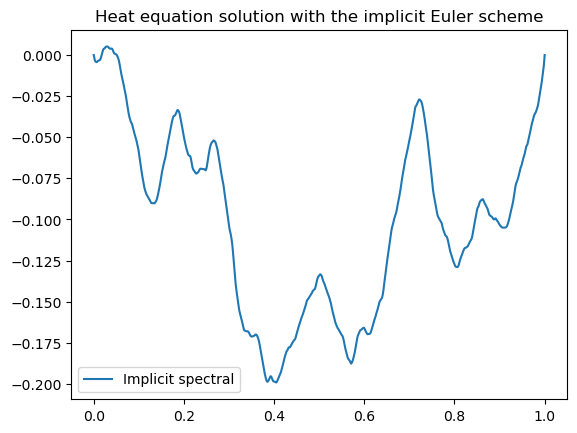

In [151]:
h  = 1/(6*100) #1e-3
T = 5
sigma = 0.35
N_bm = 2000
c_final, c_history, BM = OU_EM_implicit(T, h , coef_init,  laplace_eigenvalues, sigma ,key, record = True, N_bm = N_bm)

u_final_implicit = evaluate_function(x, c_final, L=upper - lower)
plt.plot(x, u_final_implicit, label = "Implicit spectral")
plt.legend()
plt.title("Heat equation solution with the implicit Euler scheme")
plt.show()

# Applying to our method
We solve
\begin{align}
&u_0 = g(x) \\
&[u_{n+1}, \psi] = [u_n, \psi] + h [\Delta u_{n+1}, \psi] + [\Delta W_n, \psi]
\end{align}

Given the expansion of the space time white noise as

$$
dW_t = \sum_{i=1}^N dB_i(t) \phi_i
$$
we obtain the SDE 

\begin{align}
[u_{n+1}, \psi] = [u_n, \psi] + h [\Delta u_{n+1}, \psi] + \sum_{i=1}^N \Delta B^i_{n} [\phi_i, \psi]
\end{align}

We can write 
$$
 \sum_{i=1}^N \Delta B^i_{n} [\phi_i, \psi] = [\bold{\phi}, \bold{\psi}]\Delta B_n
$$

In [152]:
def eigenfunction(x, n, L):
    return jnp.sin(jnp.pi*n*x/L)*jnp.sqrt(2/L)

vmap_eigenfunction = vmap(eigenfunction, (None, 0, None))

In [153]:
root_eigenfunctions = vmap_eigenfunction(root_psi, jnp.arange(1, N_bm+1), upper - lower)
proj_tent = jnp.sum(root_eigenfunctions*psi_matrix[None], axis = -1)
eigen_eval = vmap_eigenfunction(x, jnp.arange(1, N_bm+1), upper - lower)

In [154]:
# Evaluate the solution at all points in time
u_history = jnp.einsum('ij,kj->ki',  eigen_eval[:n_coef].T, c_history)

In [155]:
# Project the solution on the tent function basis at each point in time
u_proj_history = jnp.einsum('ij,kj->ki',  proj_tent[:n_coef].T, c_history)
u_init_proj = jnp.sum(psi_matrix*evaluate_function(root_psi, coef_init, L=upper - lower), axis = -1)

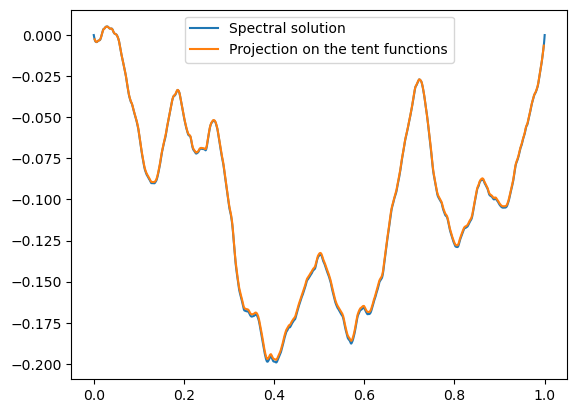

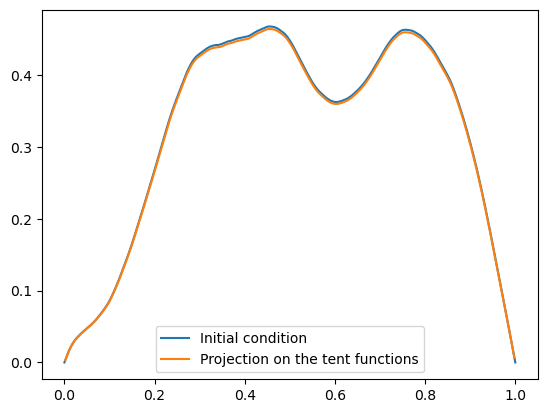

In [156]:
i = -1

plt.figure()
plt.plot(x, u_history[i], label = "Spectral solution")
plt.plot(centers, u_proj_history[i], label = "Projection on the tent functions")
plt.legend()
plt.show()

plt.figure()
plt.plot(x, u_init, label = "Initial condition")
plt.plot(centers, u_init_proj, label = "Projection on the tent functions") 
plt.legend()
plt.show()

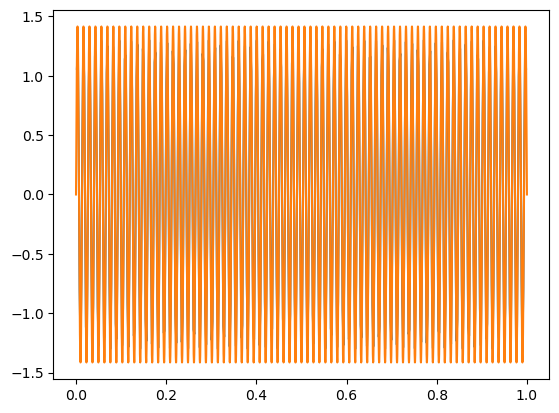

In [157]:
i = 150
plt.plot(centers, proj_tent[i])
plt.plot(x, eigen_eval[i])

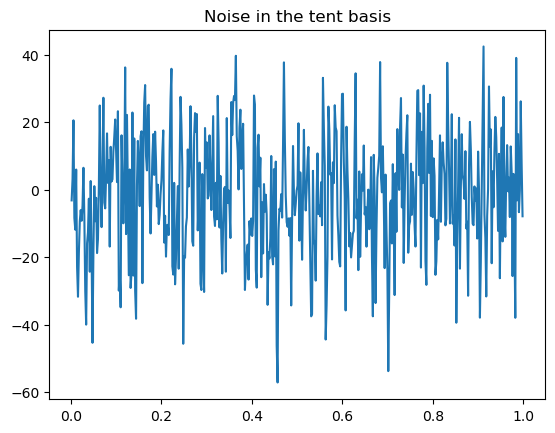

In [158]:
i = -5
plt.plot(centers,proj_tent.T@BM[i])
plt.title('Noise in the tent basis')
plt.show()

In [159]:
def implicit_EM_expansion(T, h, linear_solver, y_init,sigma, stiffness_matrix, proj_tent,BM, reg, record = False):
    L_stiff = scipy.linalg.cho_factor(stiffness_matrix)
    N_tent = stiffness_matrix.shape[0]   

    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    y = y_init

    #noise = []
    history = []
    for i in range(N):
        # Sample from the space time white noise
        xi = proj_tent.T@BM[i] 



        # Create the right hand side
        rhs = y +  jnp.sqrt(h)*sigma*xi
        #print(xi[0])

        # Solve the linear system
        linear_solver.solve(rhs, reg, L_stiff, compute_residuals = False)

        # Update the rhs
        y = linear_solver.evaluate_solution_psi()    
        if record:
            history.append(linear_solver.c)    
        #print(y.shape)
    if record:
        return y, linear_solver, jnp.stack(history)
    return y, linear_solver

In [160]:
length_scale = 0.1
bc = jnp.zeros(shape = (2, )) 



linear_solver = kernel_linear_solver(length_scale, psi_matrix, root_psi, boundary, bc, h)
root_identity = jnp.ones_like(root_psi)

start = time.time()
linear_solver.build_matrices(root_identity)
linear_solver.create_K_psi()
linear_solver.create_K_eval(x)
end = time.time()
print("Time to build the matrices", jnp.round(end - start, 5))

start = time.time()
y, linear_solver, c_kernel_history= implicit_EM_expansion(T, h, linear_solver, u_init_proj, sigma, stiffness_matrix, proj_tent,BM,  None, record = True)
end = time.time()
print("Time to integrate the system", jnp.round(end - start, 5))

Time to build the matrices 1.97632
Time to integrate the system 19.11964


In [161]:
pred_kernel = jnp.einsum('ij,kj->ki', linear_solver.K_eval, c_kernel_history)

In [162]:
white_noise = jnp.einsum('ij,kj->ki', proj_tent.T, BM)

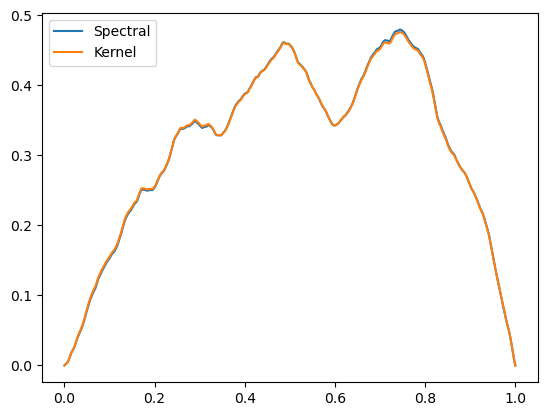

In [163]:
i = 0
plt.plot(x, u_history[i], label = "Spectral")
plt.plot(x, pred_kernel[i], label = "Kernel")
plt.legend()

## Plotting in space time

In [164]:
x = jnp.linspace(lower, upper, 10000)
time_span = jnp.arange(0, T, h)
# Define data for the surfaces


In [165]:
u_history.shape, white_noise.shape, x.shape

((3000, 10000), (3000, 498), (10000,))

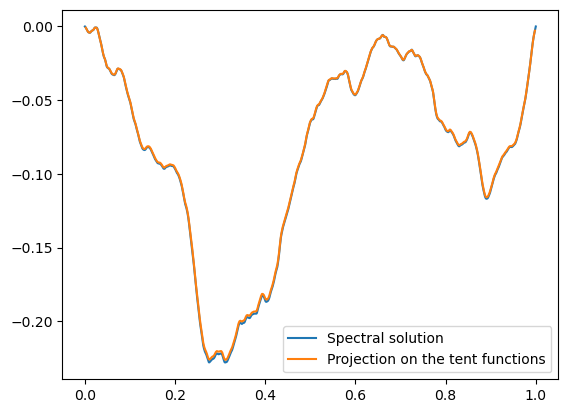

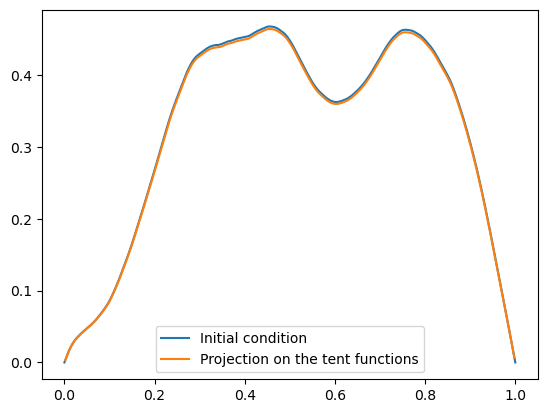

In [166]:
i = 1000

plt.figure()
plt.plot(x, u_history[i], label = "Spectral solution")
plt.plot(centers, u_proj_history[i], label = "Projection on the tent functions")
plt.legend()
plt.show()

plt.figure()
plt.plot(x, u_init, label = "Initial condition")
plt.plot(centers, u_init_proj, label = "Projection on the tent functions") 
plt.legend()
plt.show()

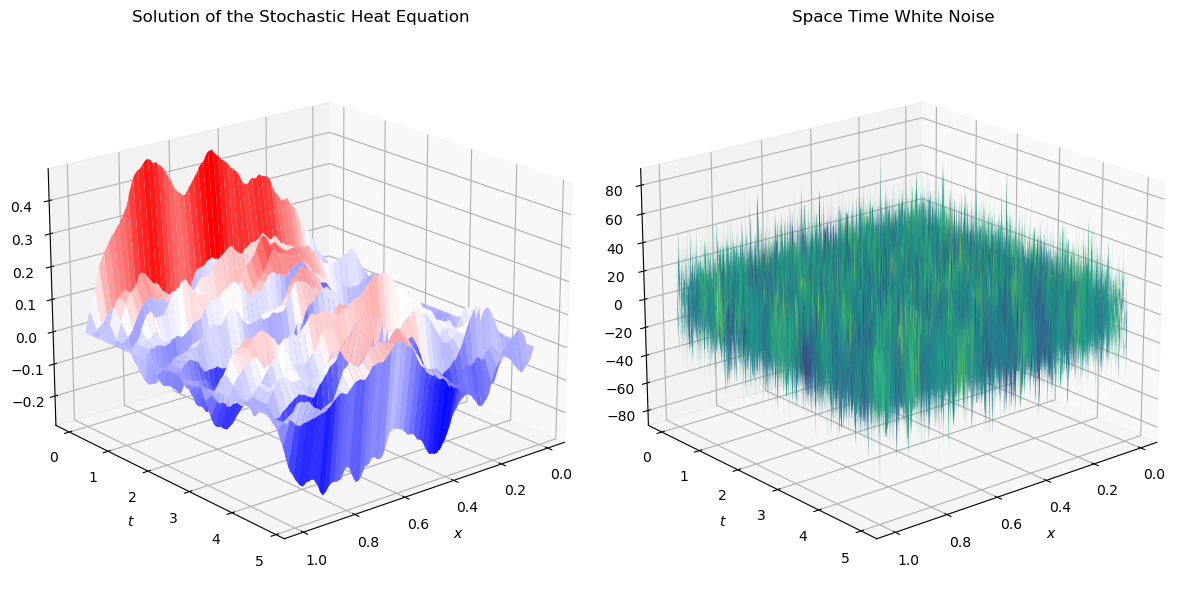

In [169]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



# Create a figure with two 3D subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), subplot_kw={'projection': '3d'})

# Surface plot on the first axis
X, Y = jnp.meshgrid(x, time_span[::100])
ax1.plot_surface(X, Y, u_history[::100], cmap='bwr')
ax1.set_title('Solution of the Stochastic Heat Equation')
ax1.view_init(elev=20, azim=50)  # Adjust elevation and azimuthal angle as desired
ax1.set_xlabel(r'$x$')
ax1.set_ylabel(r'$t$')

# Surface plot on the second axis
X, Y = jnp.meshgrid(centers, time_span)
ax2.set_title('Space Time White Noise')
ax2.plot_surface(X, Y, white_noise, cmap='viridis')
ax2.view_init(elev=20, azim=50) 
#ax2.view_init(elev=20, azim=-50) 
ax2.set_xlabel(r'$x$')
ax2.set_ylabel(r'$t$')


plt.tight_layout()
plt.show()


In [ ]:
prediction_dictionary = {"Spectral": u_history, "Kernel": pred_kernel}

  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [02:15<00:00,  2.22it/s]


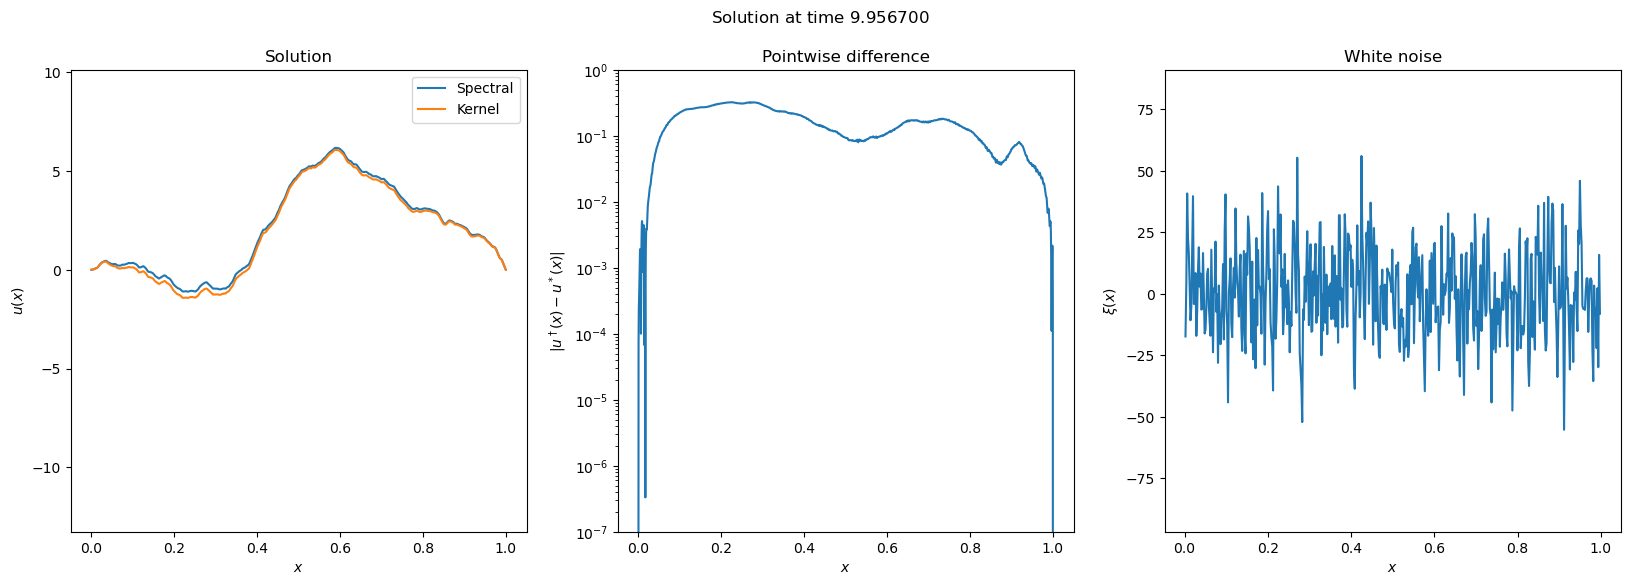

In [ ]:
save_plots(prediction_dictionary, (centers, white_noise), T, 'figures/spectral/', n_frames = 10*2)

In [ ]:
# from matplotlib.animation import FuncAnimation
# from IPython.display import HTML

# # Initialize the plot
# n_frames = u_history.shape[0]
# fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# ax[0].set_ylim(jnp.min(u_history) - 0.2, jnp.max(u_history) + 0.2)
# ax[1].set_ylim(jnp.min(u_history) - 0.2, jnp.max(u_history) + 0.2)

# # Create line objects for each plot. Initially plotting the first frame.
# line_fem, = ax[0].plot(x, u_history[0], label='FEM')
# line_kernel, = ax[0].plot(x, pred_kernel[0], label='Kernel')
# line_diff, = ax[1].plot(x, u_history[0] - pred_kernel[0])

# ax[0].legend()
# ax[0].set_title('Time step: 0')
# ax[1].set_title('Pointwise difference')

# def update(i):
#     # Update the data for each line
#     line_fem.set_data(x, u_history[i])
#     line_kernel.set_data(x, pred_kernel[i])
#     line_diff.set_data(x, u_history[i] - pred_kernel[i])
    
#     # Update the title with the current frame number
#     ax[0].set_title(f'Time step: {i}')

# # Create the animation
# animation = FuncAnimation(fig, update, frames=n_frames, blit=False, repeat=False, rc )

# plt.close(fig)  # Avoids displaying a static plot along with the animation
# HTML(animation.to_jshtml())  # Embed the animation in the notebook

# Explicit EM (can be unstable)

In [ ]:
def OU_EM(T, h , u_init,  beta, sigma ,key, record = False, N_bm = 1000):
    """
    beta is the vector of drift coefficients (in our cases these are the eigenvalues of the negative Laplacian)
    """

    # Number of time steps
    N = int(T/h)
    time = jnp.arange(h, T+h, h)
    dim = u_init.shape[0]

    # Generate a Brownian motion (these are actually the Brownian increments)
    BM = random.normal(key, (N, N_bm))

    u = jnp.copy(u_init)

    history = []
    print(sigma)
    for i in range(N):
        u = u - h*beta*u + sigma*jnp.sqrt(h)*BM[i, :dim]
        if record:
            history.append(u)
    if record:
        return u, jnp.stack(history), BM

    return u, BM